In [1]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
import pickle
import warnings
import kuka_tools as kt
# You can find kuka_tools at https://github.com/robbiemallett/custom_modules/blob/master/kuka_tools.py

/tmp/ipykernel_5886/1142447248.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
directory = '../data'

In [3]:
# pits = pickle.load(open(f'{directory}/pickles/kuka_pits.p','rb'))

In [4]:
pitnos = np.arange(1,8)
ku_ranges = np.array(pd.read_csv('../data/ku_ranges.csv')['ku'])
ka_ranges = np.array(pd.read_csv('../data/ka_ranges.csv')['ka'])
ranges = {'ku':ku_ranges,'ka':ka_ranges}

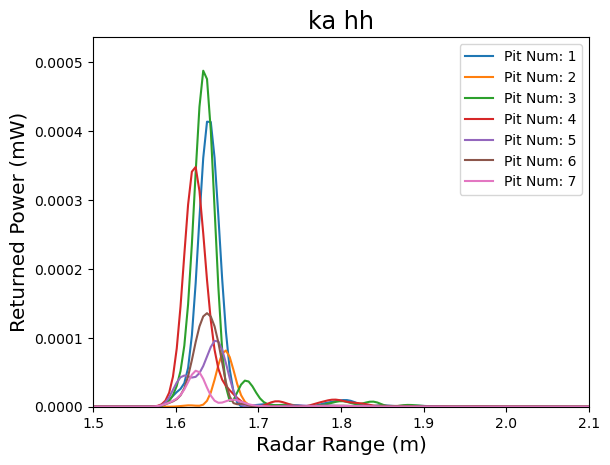

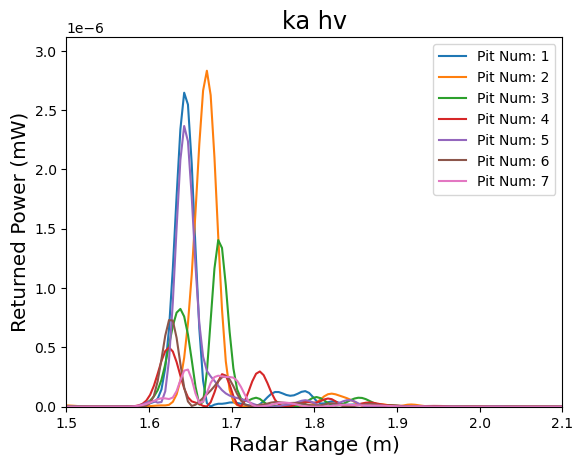

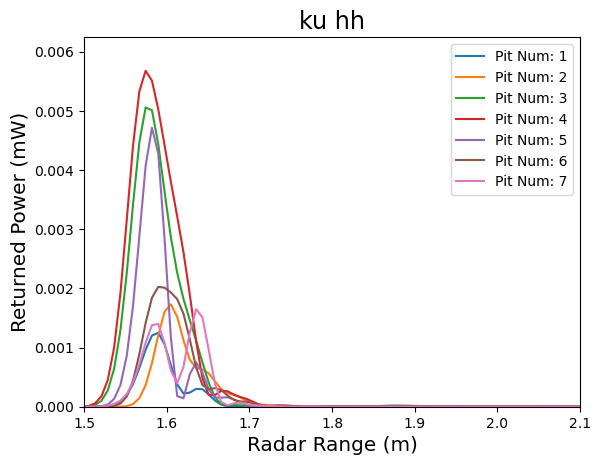

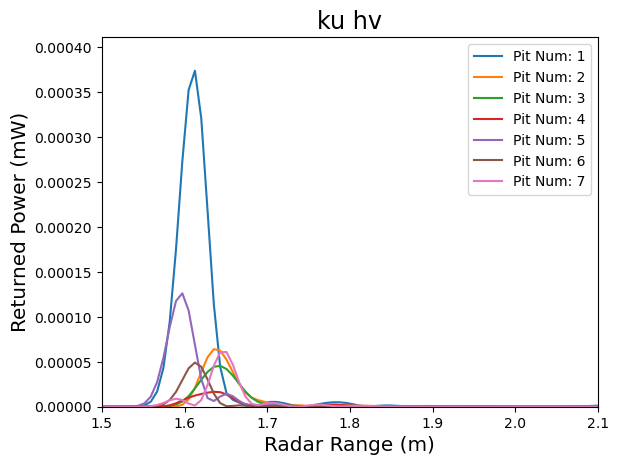

In [9]:
for freq in ['ka','ku']:

    for pol in ['hh', 'hv']:

        range_vals_for_ylim = []
    
        for pitno in pitnos:
        
            data_dict = pd.read_csv(f'../data/waveforms/North_Cove_{pitno}_{freq}.csv')
            
            snow_line = data_dict[pol]
    
            series = np.log10(snow_line)
            # Or redefine to avoid log scale:
            series = snow_line
    
            plt.plot(ranges[freq],series,label=f'Pit Num: {pitno}')
    
            range_vals_for_ylim.append(list(series[(ranges[freq]>1.4)&(ranges[freq]<2.1)]))
    
        plt.ylim(0,np.max(range_vals_for_ylim)+0.1*np.max(range_vals_for_ylim))
        
        plt.ylabel('Returned Power (mW)',fontsize='x-large')
        plt.xlabel('Radar Range (m)',fontsize='x-large')
    
        plt.xlim(1.5,2.1)
        plt.legend()
        plt.title(f'{freq} {pol}',fontsize='xx-large')

        plt.savefig(f'../figures/NC_{freq}_{pol}_all_pits.png')

        plt.show()

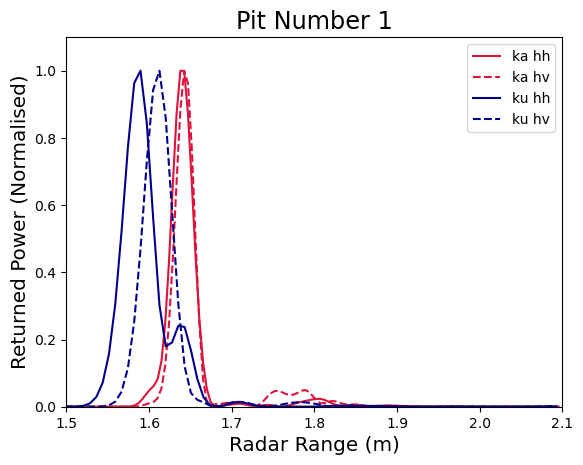

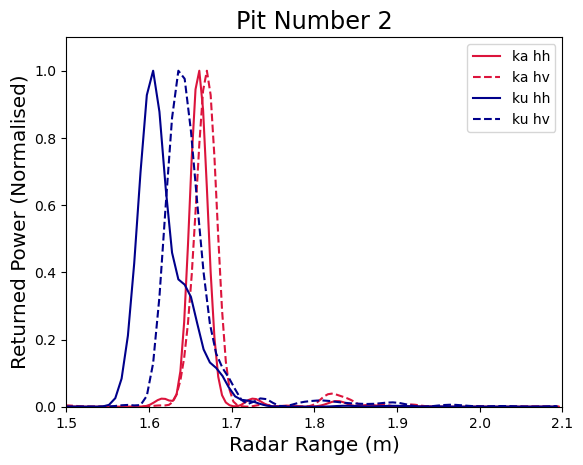

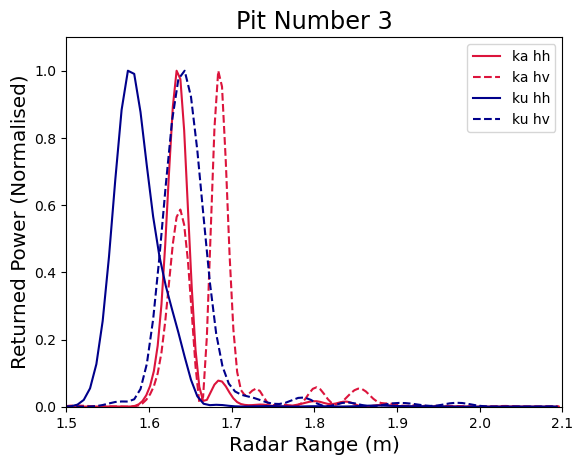

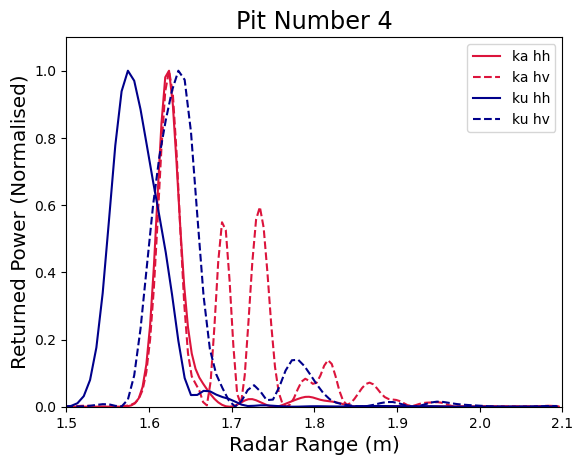

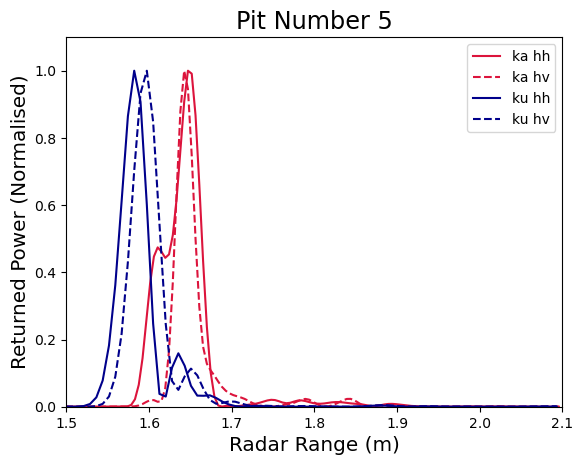

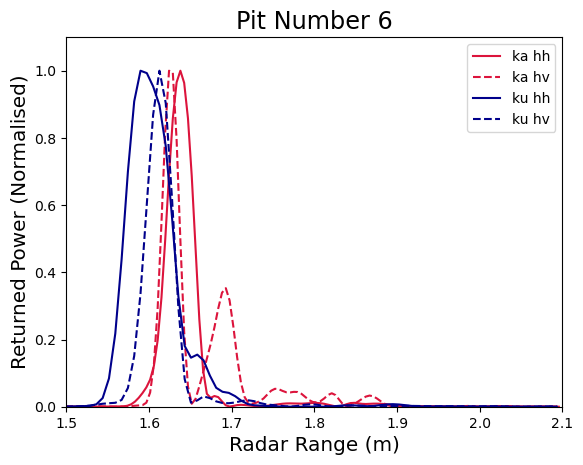

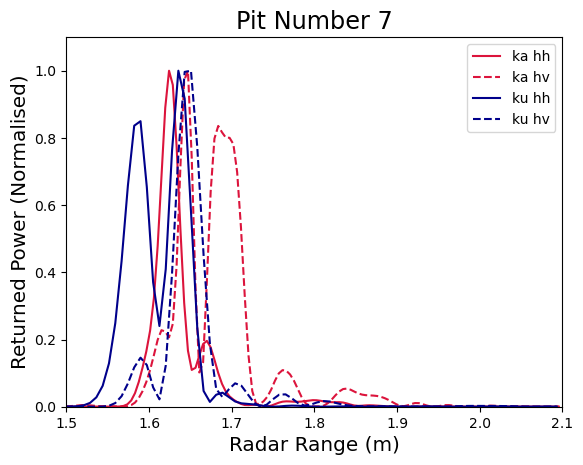

In [8]:

for pitno in pitnos:
    
    for freq,color in zip(['ka','ku'],['crimson','darkblue']):
    
        for pol,ls in zip(['hh', 'hv'],['-','--']):

            range_vals_for_ylim = []
    
            data_dict = pd.read_csv(f'../data/waveforms/North_Cove_{pitno}_{freq}.csv')
            
            snow_line = data_dict[pol]
    
            series = np.log10(snow_line)
            # Or redefine to avoid log scale:
            series = snow_line[(ranges[freq]>1.4)&(ranges[freq]<2.1)]
            r = ranges[freq][(ranges[freq]>1.4)&(ranges[freq]<2.1)]
    
            plt.plot(r,series/np.max(series),label=f'{freq} {pol}',color=color,ls=ls)
    
    
    plt.ylim(0,1.1)
    
    plt.ylabel('Returned Power (Normalised)',fontsize='x-large')
    plt.xlabel('Radar Range (m)',fontsize='x-large')

    plt.xlim(1.5,2.1)
    plt.legend()
    plt.title(f'Pit Number {pitno}',fontsize='xx-large')

    plt.savefig(f'../figures/NC_pit_{pitno}.png')

    plt.show()